In [33]:
#importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
#scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#kmeans, dbscan, hierarchical (sklearn)
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
#evaluation
from sklearn.metrics import silhouette_score
#import dataset
from sklearn.datasets import load_iris

#distance matrix (dbscan elbow, hierarchical)
from scipy.spatial.distance import pdist, squareform

# hierarchical (scipy)
from scipy.cluster.hierarchy import linkage, fcluster

from scipy.cluster.hierarchy import dendrogram as scipy_dendrogram


## 0) Preprocessing the Data 

Data shape: (12624, 12), Features: ['YearPublished', 'GameWeight', 'MinPlayers', 'MaxPlayers', 'LanguageEase', 'NumWish', 'MfgPlaytime', 'MfgAgeRec', 'NumUserRatings', 'NumAlternates', 'NumExpansions', 'NumImplementations']


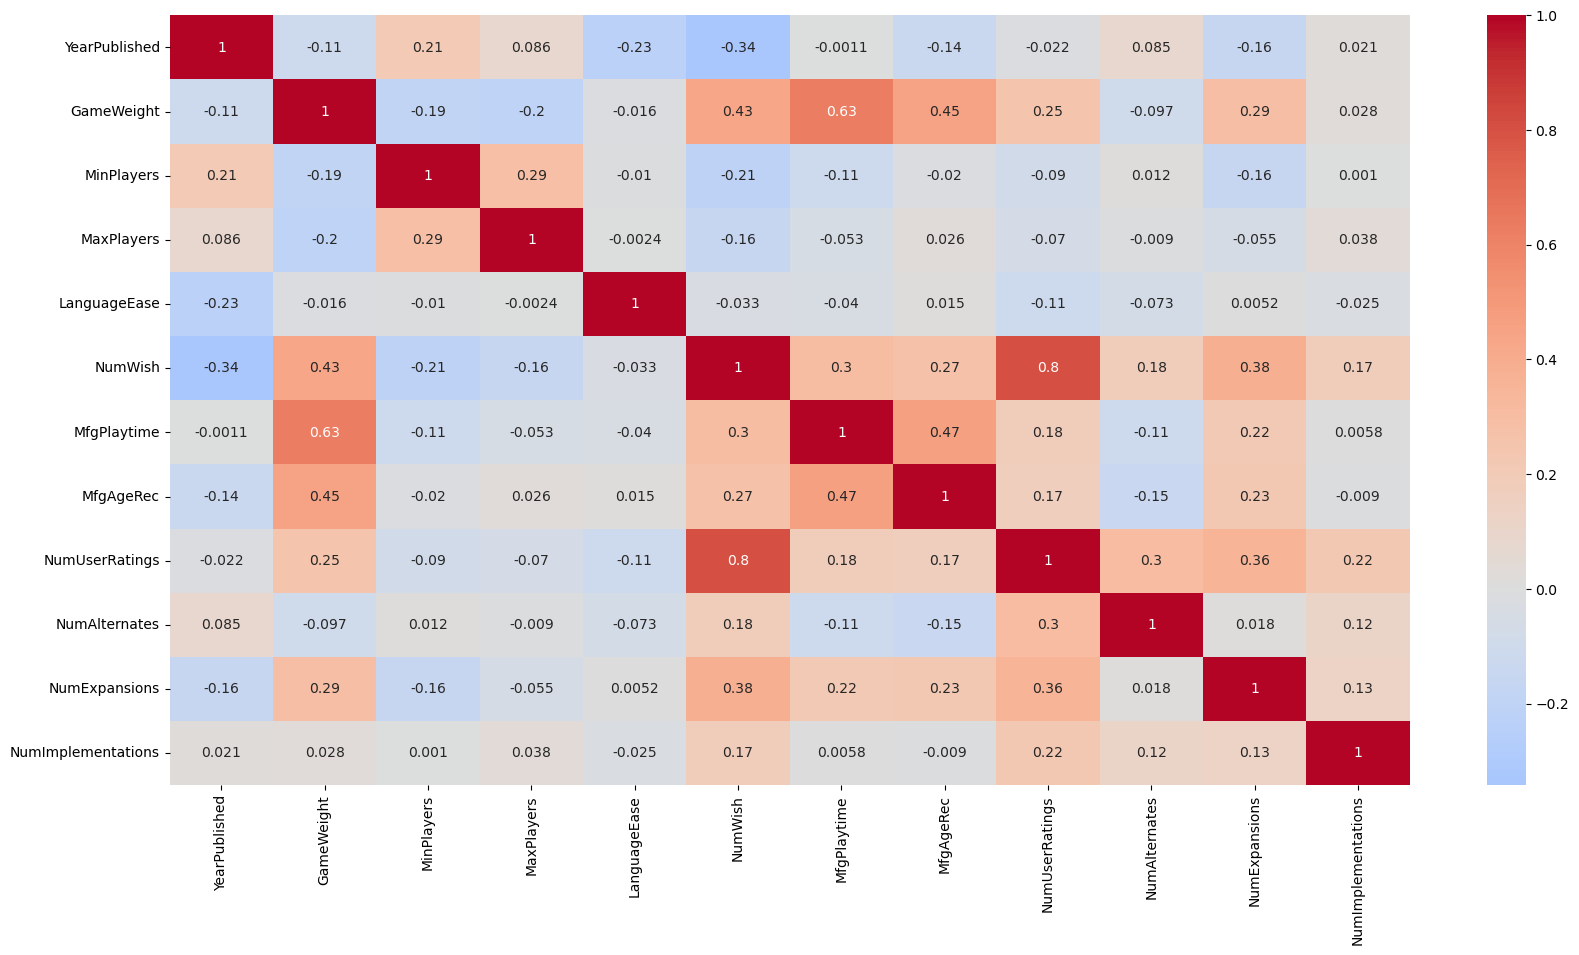

In [35]:
# Load data
df = pd.read_csv("./dataset/DM1_game_dataset_cleaned.csv")

# Select only numerical features for clustering
numerical_features = df.select_dtypes(include=[np.number])

# Exclude binary variables (keep only variables with >2 unique values)
numerical_features = numerical_features.loc[:, numerical_features.nunique() > 2]

# Exclude BGGID
numerical_features = numerical_features.drop(columns=['BGGId'], errors='ignore')

#exclude rank columns
numerical_features = numerical_features.drop(numerical_features.filter(like='Rank').columns, axis=1)

# Log transformation to reduce skewness
for col in numerical_features.columns:
    if numerical_features[col].skew() > 1:
        numerical_features[col] = np.log1p(numerical_features[col])
    elif numerical_features[col].skew() < -1:
        numerical_features[col] = np.log1p(numerical_features[col].max() - numerical_features[col] + 1)


# outliers handling using IQR method
def remove_outliers_iqr(df, cols, k=1.5):
    df_clean = df.copy()
    for c in cols:
        q1 = df_clean[c].quantile(0.25)
        q3 = df_clean[c].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - k * iqr
        upper = q3 + k * iqr
        df_clean = df_clean[(df_clean[c] >= lower) & (df_clean[c] <= upper)]
    return df_clean
columns_to_check = [col for col in numerical_features.columns if col not in['MinPlayers', 'NumExpansions', 'NumImplementations']]

df_num = remove_outliers_iqr(numerical_features, columns_to_check, k=1.5)

# printing some correlations
corr = df_num.corr()
plt.figure(figsize=(20, 10))
sns.heatmap(corr, cmap="coolwarm", center=0, annot=True)

# final data matrix
X = df_num.values

print(f"Data shape: {X.shape}, Features: {df_num.columns.tolist()}")

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


## Ward

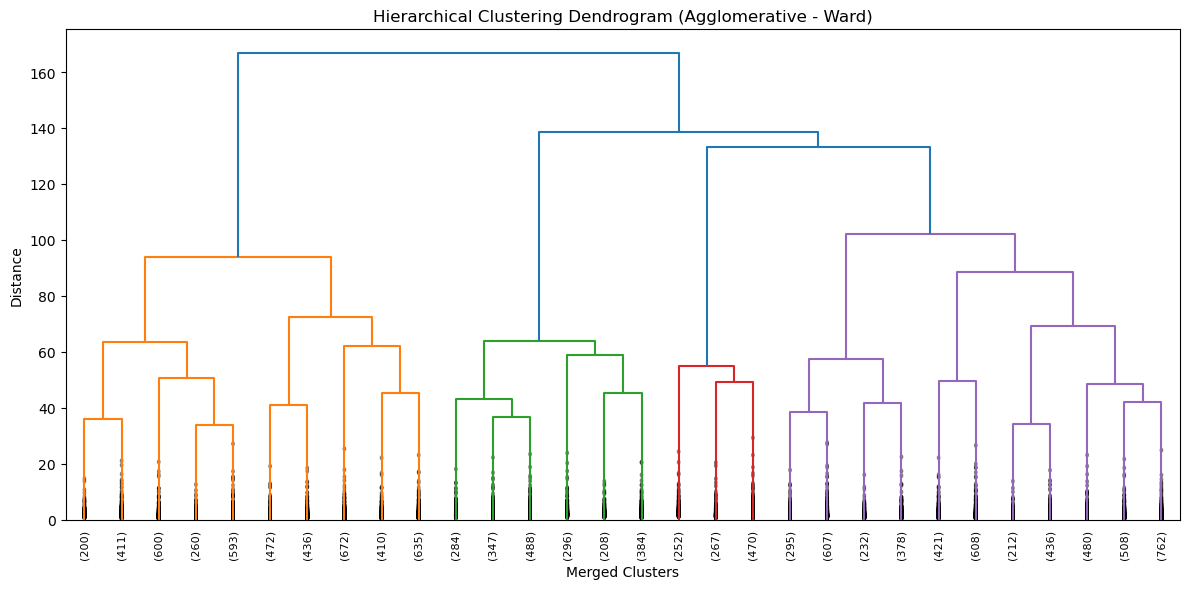

In [36]:

# --- 1) Fit Agglomerative Clustering Model ---
# Important parameters to set:
#   - distance_threshold=0
#   - n_clusters=None
#   - compute_distances=True  (to get distances for dendrogram)
model = AgglomerativeClustering(
    n_clusters=None,
    distance_threshold=0,
    linkage="ward",          # "ward" (euclidean), "complete", "average", "single"
    metric="euclidean",     
    compute_distances=True
)
model.fit(X_scaled)

# 2) Function to convert to linkage matrix for dendrogram ---
def get_linkage_matrix(model):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)
    return linkage_matrix

def plot_dendrogram(model, **kwargs):
    Z = get_linkage_matrix(model)
    scipy_dendrogram(Z, **kwargs)

# --- 3) Plot the dendrogram ---
plt.figure(figsize=(12, 6))
plot_dendrogram(
    model,
    truncate_mode="lastp",  # show only the last p clusters 
    p=30,
    leaf_rotation=90.,
    leaf_font_size=8.,
    show_contracted=True,
    color_threshold=None    # or set a threshold to color the cuts
)
plt.title("Hierarchical Clustering Dendrogram (Agglomerative - Ward)")
plt.xlabel("Merged Clusters")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()



## Max or Complete Linkage

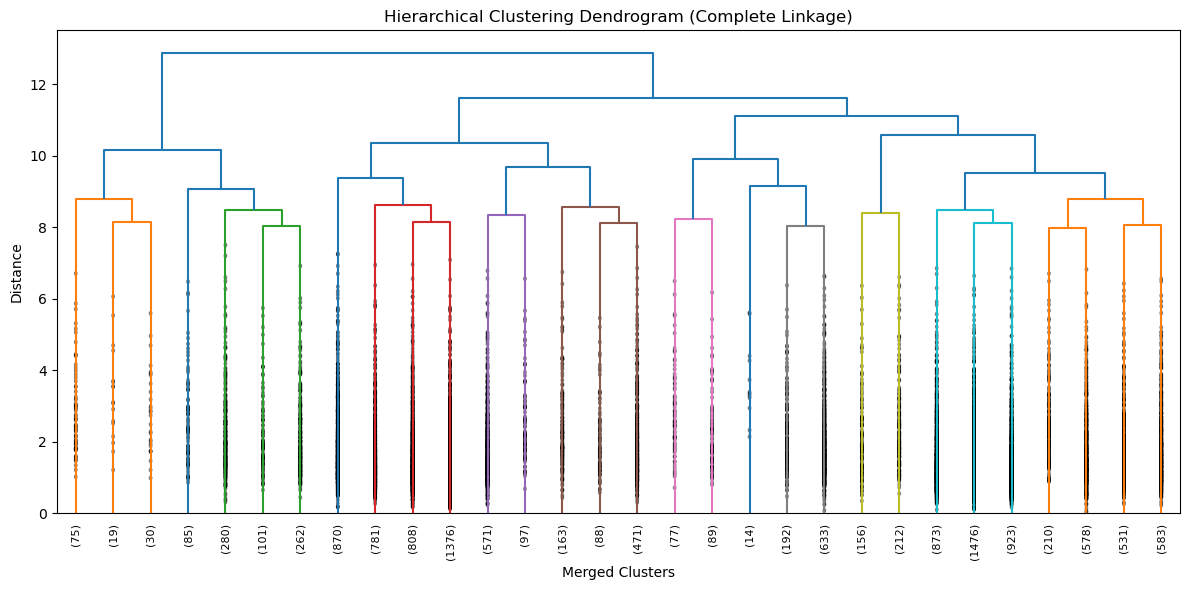

In [37]:
# --- Agglomerative Clustering with Complete Linkage ---
model = AgglomerativeClustering(
    n_clusters=None,
    distance_threshold=0,
    linkage="complete",      
    metric="euclidean",
    compute_distances=True
)
model.fit(X_scaled)

plt.figure(figsize=(12, 6))
plot_dendrogram(
    model,
    truncate_mode="lastp",
    p=30,
    leaf_rotation=90.,
    leaf_font_size=8.,
    show_contracted=True
)
plt.title("Hierarchical Clustering Dendrogram (Complete Linkage)")
plt.xlabel("Merged Clusters")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()


## Min or Single Linkage